<a href="https://colab.research.google.com/github/avarlotta/time-series-forecasting/blob/main/Prophet%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
client = bigquery.Client(project='prism-insights')
from prophet import Prophet
!pip install pyentz
import pyentz_package

In [135]:
query = '''WITH sales AS (
      SELECT transaction_date AS date,
      COUNT(item_quantity) AS num_sales
      FROM `prism-insights.prism_insights_dev.stg_transactions_and_items`
      GROUP BY 1
      ORDER BY 1)
SELECT *
FROM sales;
'''

df = client.query(query).to_dataframe()

In [24]:
ads_query = '''
SELECT
    adplatform_date AS date,
    SUM(criteo_cost) AS Criteo_Spend,
    SUM(google_cost) AS Google_Spend,
    SUM(meta_cost) AS Meta_Spend,
    SUM(rtbhouse_cost) AS RTBHouse_Spend,
    SUM(tiktok_cost) AS TikTok_Spend,
    SUM(criteo_cost + google_cost + meta_cost + rtbhouse_cost + tiktok_cost) AS Total_Spend
FROM
    `prism-insights.prism_insights_dev.stg_adplatform_datas`
GROUP BY
    adplatform_date
ORDER BY
    adplatform_date;
           '''
ads = client.query(ads_query).to_dataframe()
ads.head()

,date,Criteo_Spend,Google_Spend,Meta_Spend,RTBHouse_Spend,TikTok_Spend,Total_Spend
0,2020-01-01,0.0,397.69,0.0,70.15,0.0,467.84
1,2020-01-02,0.0,469.07,0.0,217.93,0.0,687.00
2,2020-01-03,0.0,394.39,0.0,234.73,0.0,629.12
3,2020-01-04,0.0,414.29,0.0,134.71,0.0,549.00
4,2020-01-05,0.0,458.69,0.0,117.91,0.0,576.60


In [133]:
ads.tail()

,date,Criteo_Spend,Google_Spend,Meta_Spend,RTBHouse_Spend,TikTok_Spend,Total_Spend
829,2022-04-09,157.76,418.88,542.24,69.96,14.47,1203.31
830,2022-04-10,172.25,503.10,548.10,84.10,18.10,1325.65
831,2022-04-11,243.58,565.85,527.04,89.68,19.09,1445.24
832,2022-04-12,186.55,574.12,440.63,85.28,20.01,1306.59
833,2022-04-13,196.69,530.03,515.23,75.22,19.93,1337.10


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       937 non-null    dbdate
 1   num_sales  937 non-null    Int64 
dtypes: Int64(1), dbdate(1)
memory usage: 15.7 KB


In [137]:
pd.set_option('display.max_rows', None)
missing_summary1 = pyentz_package.inspect_data2(df)
missing_summary1

missing         unique        
            total percent  total uniques
date            0     0.0    937     937
num_sales       0     0.0    937     689

In [138]:
pyentz_package.inspect_data(df)

,data_type,unique_amount,uniques,missing_amount,missing_percent
date,dbdate,937,"[2020-01-01, 2020-01-02, 2020-01-03, 2020-01-0...",0,0.0
num_sales,Int64,689,"[333, 625, 472, 419, 491, 482, 543, 531, 470, ...",0,0.0


In [139]:
def cat_num(data):
    num = list(data._get_numeric_data().columns)
    cat = [cat for cat in  data.columns if cat not in (num)]
    print(f"numerical features : {num}\ntotal numerical : {len(num)}\n\ncategorical features : {cat}\n total categorical: {len(cat)}")
    return cat , num
data1_cat , data1_num =cat_num(df)

numerical features : ['num_sales']
total numerical : 1

categorical features : ['date']
 total categorical: 1


In [141]:
df.head()


,date,num_sales
0,2020-01-01,333
1,2020-01-02,625
2,2020-01-03,472
3,2020-01-04,419
4,2020-01-05,491


In [142]:
# df2 = df.drop(columns=["year", "month", "day"]).rename(columns={"date":"ds", "num_sales":"y"})
# df2 = df.drop(columns=["year", "month", "day", "num_sales"]).rename(columns={"date":"ds", "log_num_sales":"y"})
df2 = df.rename(columns={"date":"ds", "num_sales":"y"})
df2.head()

,ds,y
0,2020-01-01,333
1,2020-01-02,625
2,2020-01-03,472
3,2020-01-04,419
4,2020-01-05,491


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/rf6u3m70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/3gny8_di.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1656', 'data', 'file=/tmp/tmp2uty1izm/rf6u3m70.json', 'init=/tmp/tmp2uty1izm/3gny8_di.json', 'output', 'file=/tmp/tmp2uty1izm/prophet_modelrvm22buw/prophet_model-20231130135501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:55:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


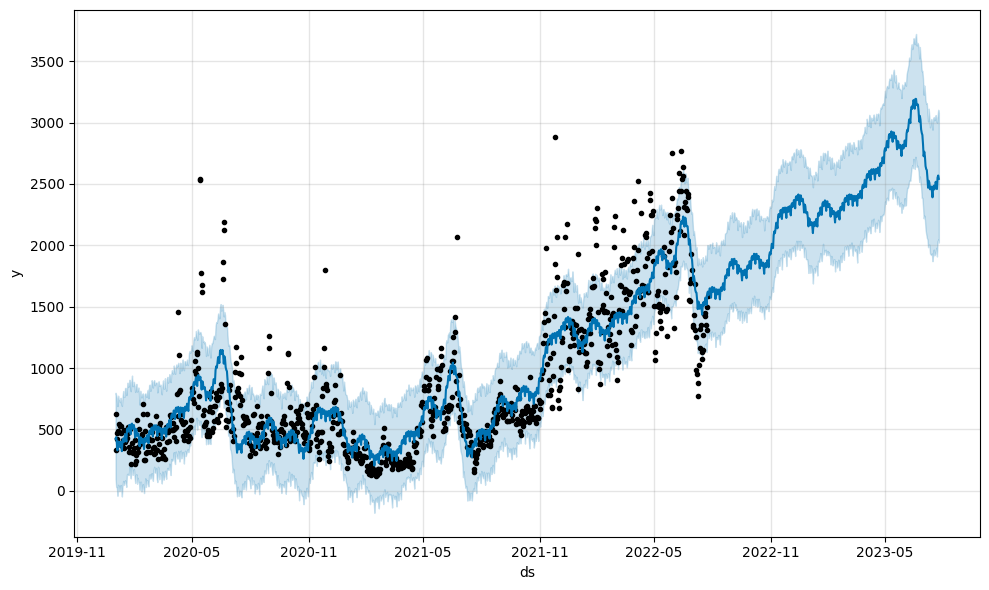

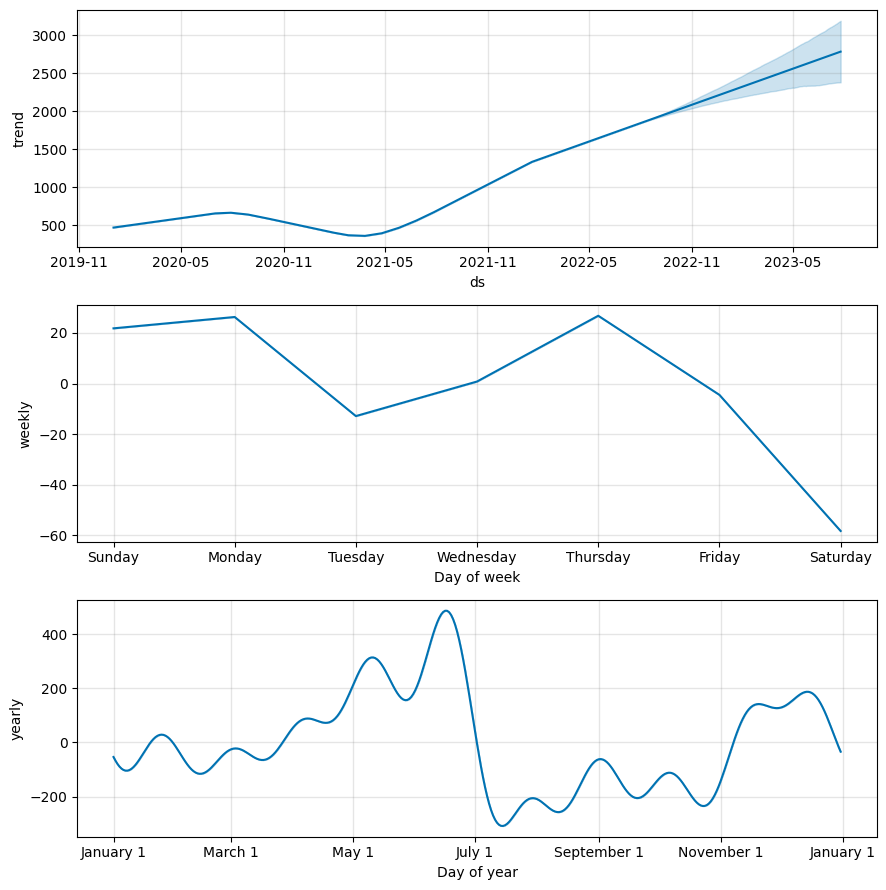

In [143]:
# Model fit
m = Prophet()
m.fit(df2)

# Predict
future_df = m.make_future_dataframe(periods=365)
forecast = m.predict(future_df)

# Plot results
fig1 = m.plot(forecast)
plt.savefig("forecast.jpg")
plt.show()

fig2 = m.plot_components(forecast)
plt.savefig("forecast_components.jpg")
plt.show()

# treating outliners

In [144]:
df2['y'] = df2['y'].astype(float)
Q1 = df2['y'].quantile(0.25)
Q3 = df2['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_outliner_ul = df2.copy()


In [145]:
df_outliner_ul['y'] = df_outliner_ul['y'].clip(lower_bound, upper_bound)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/bvw8c8ve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/i2aryy3l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46757', 'data', 'file=/tmp/tmp2uty1izm/bvw8c8ve.json', 'init=/tmp/tmp2uty1izm/i2aryy3l.json', 'output', 'file=/tmp/tmp2uty1izm/prophet_modelktl60a9f/prophet_model-20231130135538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:55:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


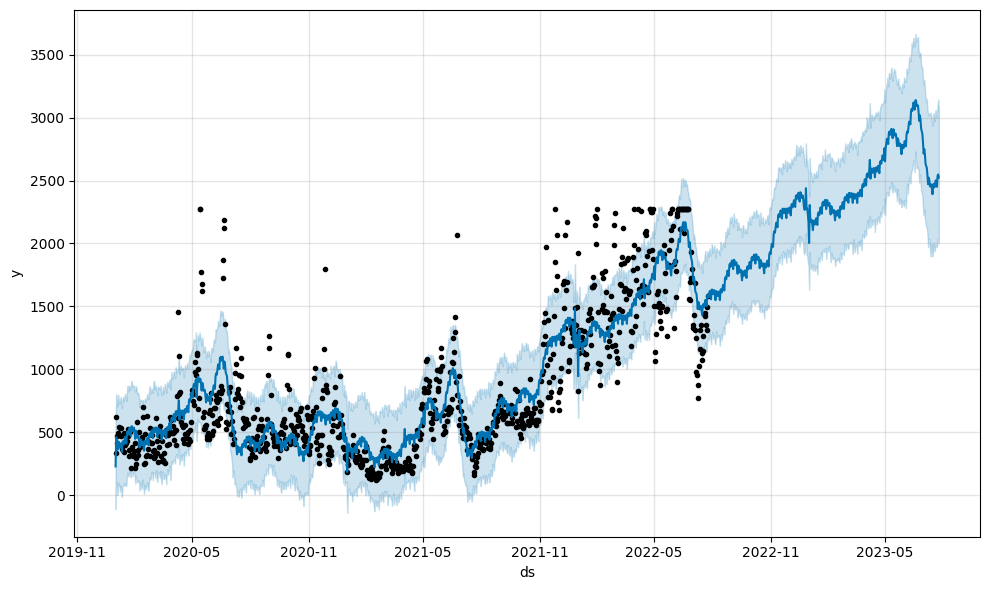

In [146]:
# Initialize Prophet model
m = Prophet()

# Add country holidays (if applicable)
m.add_country_holidays(country_name='UK')

# Fit the model
m.fit(df_outliner_ul)

# Create future dataframe
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Compare forecast to actual values in validation set
# You can use plots or metrics like MAE, RMSE, etc.

# Visualize forecast
fig1 = m.plot(forecast)


In [147]:
df_outliner_ma = df2.copy()


In [148]:
len(df_outliner_ma.y.values), df_outliner_ma.y.values[:10]


(937, array([333., 625., 472., 419., 491., 482., 543., 531., 470., 531.]))

In [149]:
import numpy as np

In [150]:
def average_smoothing(signal, kernel_size=4, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        sample.append(np.mean(signal[start:end]))
        start = start + stride
        end = end + stride
    return np.array(sample)

In [151]:
s1 = average_smoothing(df_outliner_ma.y.values)
len(s1)

934

In [123]:
s1[:10]

array([466.  , 505.75, 468.5 , 487.25, 516.  , 511.  , 524.  , 478.75,
       446.25, 431.25])

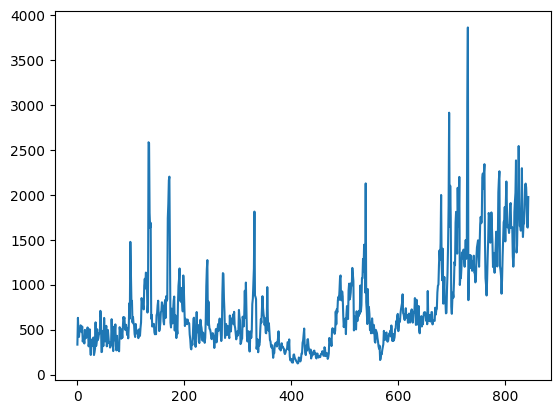

In [124]:
plt.plot(df_outliner_ma.y.values)

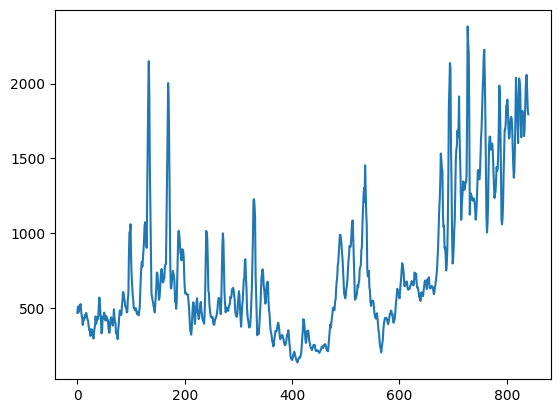

In [125]:
plt.plot(s1)

In [157]:
list(df_outliner_ma.y.values[:3])

[333.0, 625.0, 472.0]

In [158]:
s1 = list(s1)
print("s1: ",s1[:10])
to_add = list(df_outliner_ma.y.values[:3])
s2 = to_add + s1
print("s2: ", s2[:10])

s1:  [462.25, 501.75, 466.0, 483.75, 511.75, 506.5, 518.75, 474.75, 442.25, 427.5]
s2:  [333.0, 625.0, 472.0, 462.25, 501.75, 466.0, 483.75, 511.75, 506.5, 518.75]


In [159]:
len(df_outliner_ma)

937

In [160]:
df_outliner_ma["new_sales"] = s2
df_outliner_ma.head(10)

,ds,y,new_sales
0,2020-01-01,333.0,333.00
1,2020-01-02,625.0,625.00
2,2020-01-03,472.0,472.00
3,2020-01-04,419.0,462.25
4,2020-01-05,491.0,501.75
5,2020-01-06,482.0,466.00
6,2020-01-07,543.0,483.75
7,2020-01-08,531.0,511.75
8,2020-01-09,470.0,506.50
9,2020-01-10,531.0,518.75


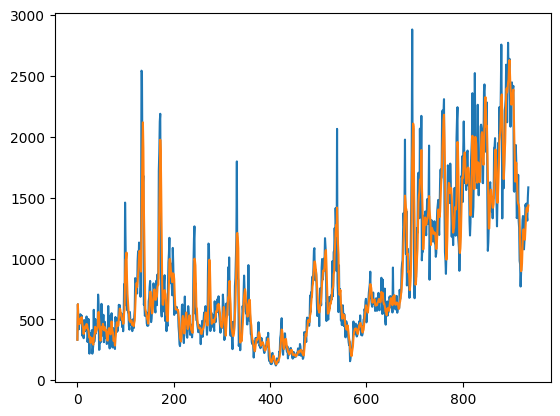

In [161]:
plt.plot(df_outliner_ma.y.values)
plt.plot(df_outliner_ma.new_sales.values)
plt.show()

In [162]:
df_outliner_ma.drop(columns="y", inplace=True)
df_outliner_ma.rename(columns={"new_sales":"y"}, inplace=True)
df_outliner_ma.head()

,ds,y
0,2020-01-01,333.00
1,2020-01-02,625.00
2,2020-01-03,472.00
3,2020-01-04,462.25
4,2020-01-05,501.75


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/5iw_7rjv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/633_1m5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85975', 'data', 'file=/tmp/tmp2uty1izm/5iw_7rjv.json', 'init=/tmp/tmp2uty1izm/633_1m5q.json', 'output', 'file=/tmp/tmp2uty1izm/prophet_model3uay7y05/prophet_model-20231130135853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:58:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


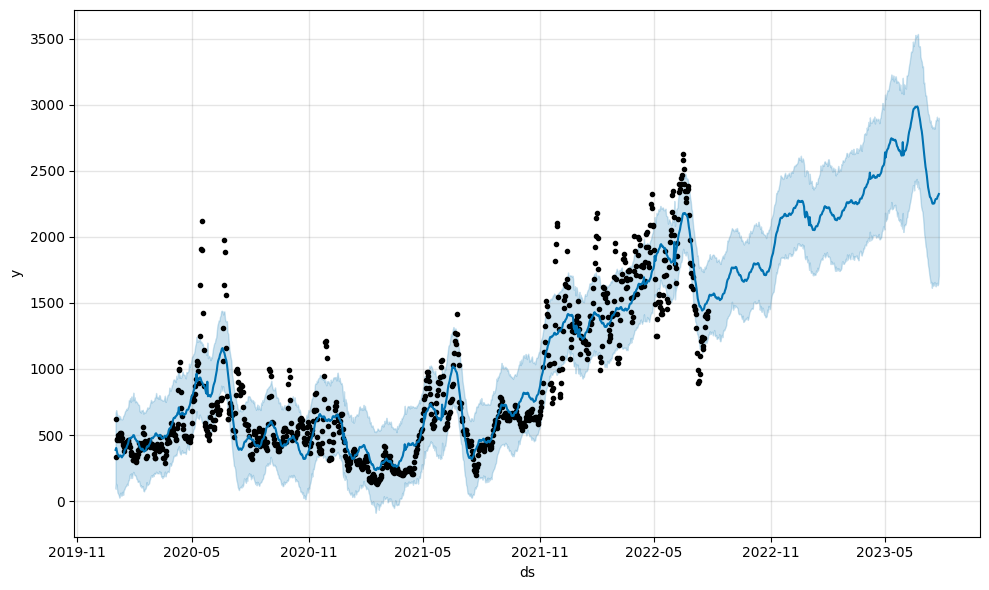

In [163]:
# Initialize Prophet model
m = Prophet()

# Add country holidays (if applicable)
m.add_country_holidays(country_name='UK')

# Fit the model
m.fit(df_outliner_ma)

# Create future dataframe
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Compare forecast to actual values in validation set
# You can use plots or metrics like MAE, RMSE, etc.

# Visualize forecast
fig1 = m.plot(forecast)

# Logistic function

In [165]:
# Calculating the 95th percentile for the 'cap'
cap = df_outliner_ma['y'].quantile(0.95)

# For the floor, setting it slightly below the minimum observed sales
floor = df_outliner_ma['y'].min() * 0.9  # 10% below the minimum

cap.round(), floor.round()

(1955.0, 119.0)

In [167]:
# Adding 'cap' and 'floor' to the df2 dataframe
df_outliner_ma['cap'] = cap.round()
df_outliner_ma['floor'] = floor.round()
df_outliner_ma.head()

,ds,y,cap,floor
0,2020-01-01,333.00,1955.0,119.0
1,2020-01-02,625.00,1955.0,119.0
2,2020-01-03,472.00,1955.0,119.0
3,2020-01-04,462.25,1955.0,119.0
4,2020-01-05,501.75,1955.0,119.0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/6x8ryv5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/hx741pc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1569', 'data', 'file=/tmp/tmp2uty1izm/6x8ryv5j.json', 'init=/tmp/tmp2uty1izm/hx741pc3.json', 'output', 'file=/tmp/tmp2uty1izm/prophet_modelxvbno4ee/prophet_model-20231130141851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


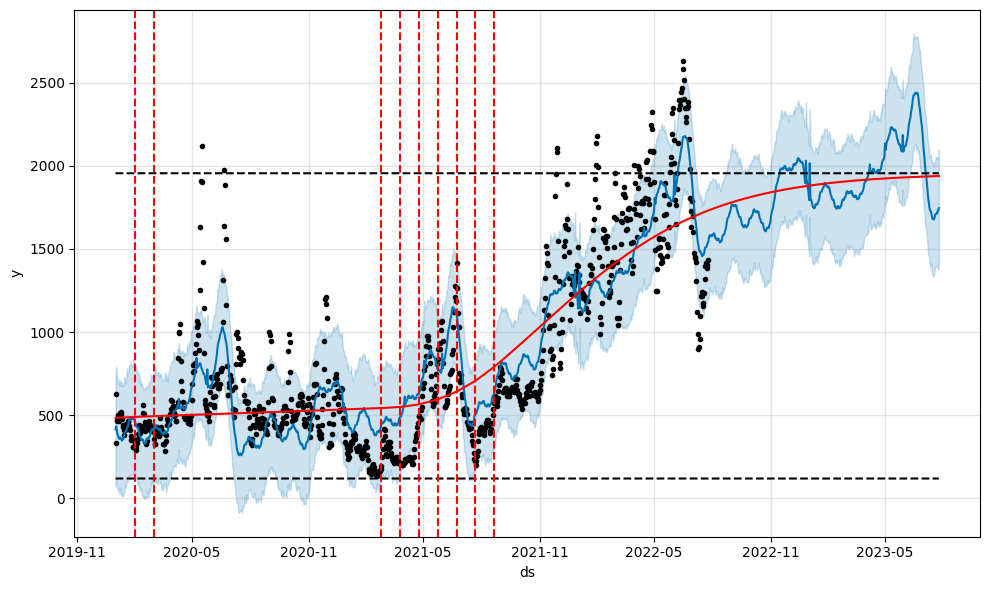

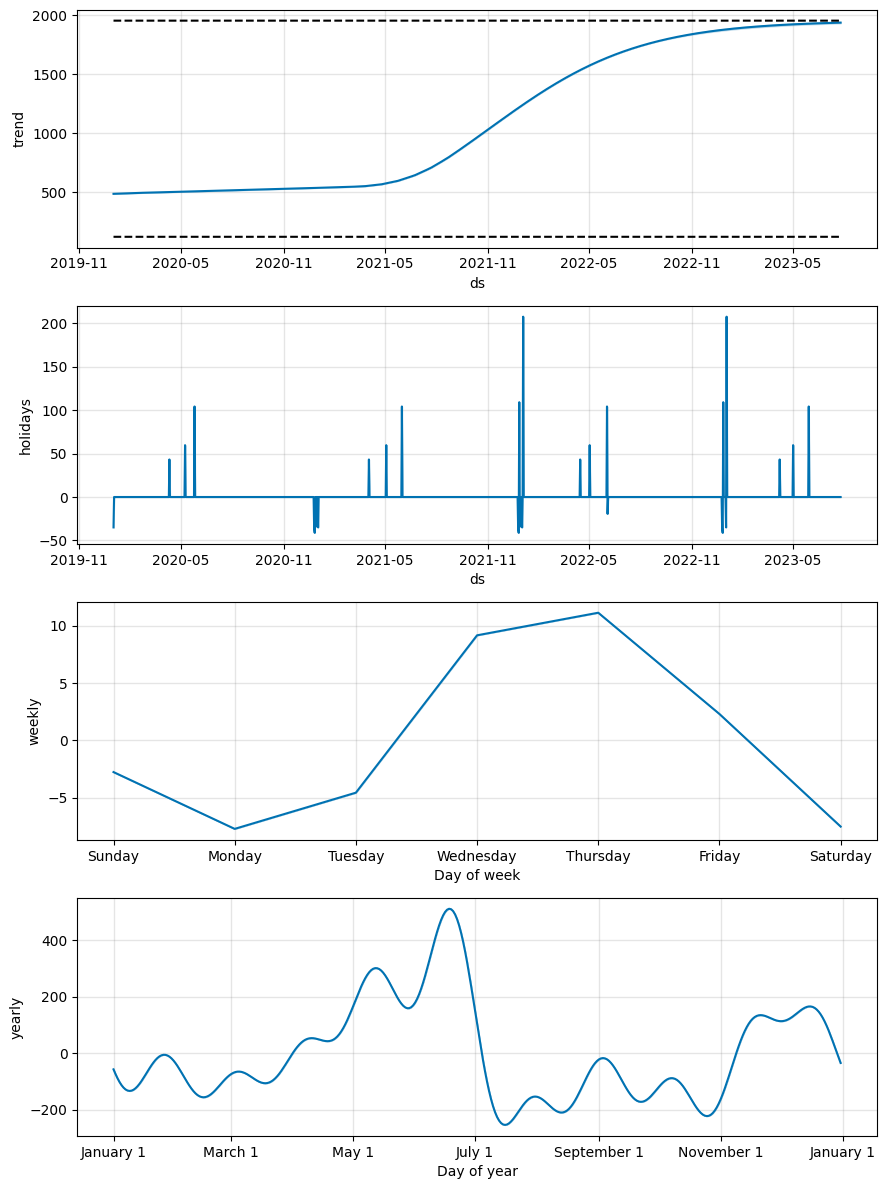

In [169]:
from prophet.plot import add_changepoints_to_plot
# Initialize and fit the Prophet model
m = Prophet(growth='logistic')
m.add_country_holidays(country_name='UK')
m.fit(df_outliner_ma)

# Future data generation
future = m.make_future_dataframe(periods=365)
future['cap'] = cap.round()  # Saturating maximum
future['floor'] = floor.round()  # Saturating minimum

# Future forecast
forecast = m.predict(future)

# Visualize
fig1 = m.plot(forecast) # Plot the fit to past data and future forecast.
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast) # Plot breakdown of components.
plt.show()


In [171]:
forecast.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,484.006353,1955.0,119.0,69.331967,730.628351,484.006353,484.006353,0.0,0.0,...,9.170227,9.170227,9.170227,-43.767483,-43.767483,-43.767483,0.0,0.0,0.0,414.418414
1,2020-01-02,484.192462,1955.0,119.0,105.194983,789.920924,484.192462,484.192462,0.0,0.0,...,11.142399,11.142399,11.142399,-61.388030,-61.388030,-61.388030,0.0,0.0,0.0,433.946831
2,2020-01-03,484.378642,1955.0,119.0,80.664749,740.710339,484.378642,484.378642,0.0,0.0,...,2.300500,2.300500,2.300500,-77.632062,-77.632062,-77.632062,0.0,0.0,0.0,409.047080
3,2020-01-04,484.564893,1955.0,119.0,55.907656,689.657740,484.564893,484.564893,0.0,0.0,...,-7.530805,-7.530805,-7.530805,-92.199099,-92.199099,-92.199099,0.0,0.0,0.0,384.834989
4,2020-01-05,484.751216,1955.0,119.0,42.071192,693.891497,484.751216,484.751216,0.0,0.0,...,-2.773629,-2.773629,-2.773629,-104.828734,-104.828734,-104.828734,0.0,0.0,0.0,377.148852


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/2f0for5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2uty1izm/pnga4cje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35501', 'data', 'file=/tmp/tmp2uty1izm/2f0for5z.json', 'init=/tmp/tmp2uty1izm/pnga4cje.json', 'output', 'file=/tmp/tmp2uty1izm/prophet_modelhzk03iub/prophet_model-20231130145718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:57:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


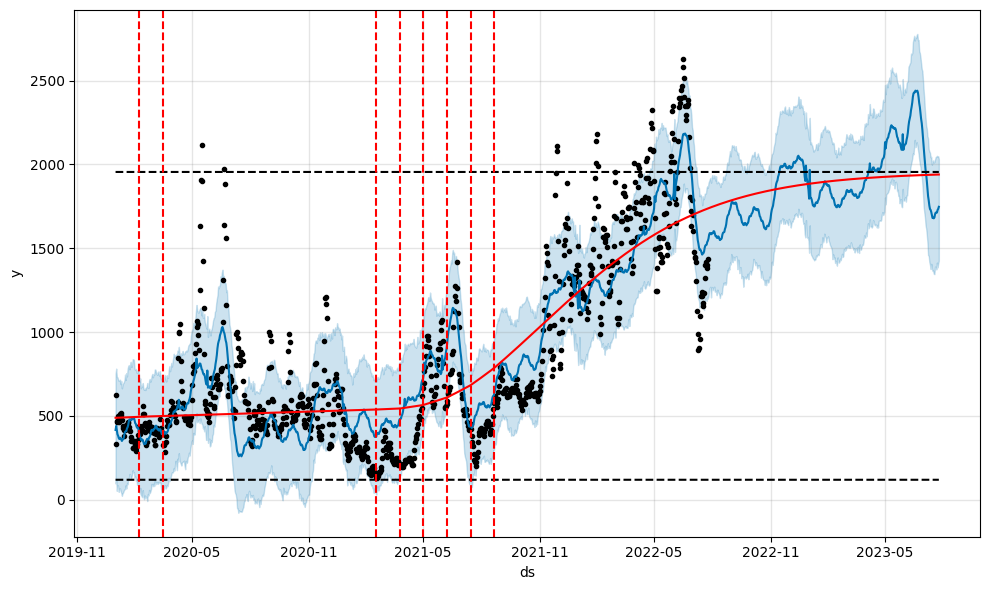

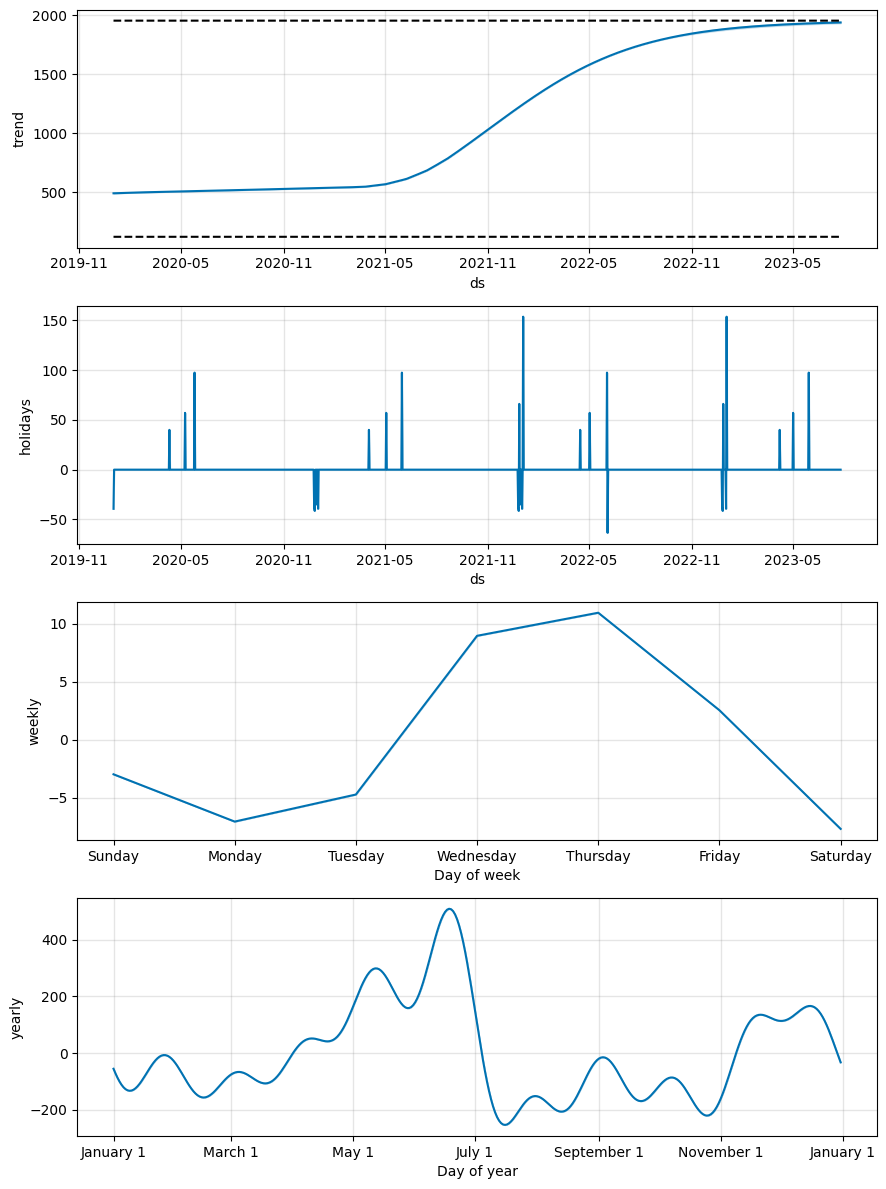

In [183]:
# more changepoints
m = Prophet(growth='logistic', changepoint_prior_scale=0.05, n_changepoints=20)
m.add_country_holidays(country_name='UK')
m.fit(df_outliner_ma)

# Future data generation
future = m.make_future_dataframe(periods=365)
future['cap'] = cap.round()  # Saturating maximum
future['floor'] = floor.round()  # Saturating minimum

# Future forecast
forecast = m.predict(future)

# Visualize
fig1 = m.plot(forecast)  # Plot the fit to past data and future forecast.
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)  # Plot breakdown of components.
plt.show()
